In [1]:
# from math import log, sqrt, pi, exp
# from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import linalg
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import copy
from collections import OrderedDict

from fd_adi import * 

In [2]:
T = 1
# Nx = np.array([4,4]) # x and v spaces
# Nx = np.array([2**5,2**5]) # x and v spaces
# Nx = np.array([2**6,2**6]) # x and v spaces
# Nx = np.array([2**7,2**6]) # x and v spaces
Nx = np.array([2**8,2**6]) # x and v spaces
# Nx = np.array([2**8,2**7]) # x and v spaces
# Nx = np.array([2**8,2**8]) # x and v spaces
Nx = np.array([2**9,2**6]) # x and v spaces
# Nx = np.array([2**10,2**8]) # x and v spaces
x_max = np.array([np.log(10),0.4]) # log(price), vol-vol
x_min = np.array([np.log(0.001),0.0])
dx = (x_max-x_min)/(Nx-1)
Nt = 12 # always scalar
Nt = 12*5 # weekly
# Nt = 12*5*7 # daily
t_space = np.linspace(0,T,Nt+1)
dt = t_space[1]-t_space[0]

# Input parameters
theta = 0.05; kappa = 0.3; sigma = 0.5; rho = -0.6; v0 = 0.04
theta = 0.05; kappa = 0.3; sigma = 0.1; rho = -0.6; v0 = 0.04
sigma_lv = 1.0; beta_lv = 1.0; # slv params (CEV)
r = 0.0 # always presume zero risk-free interest
# S0 = 1.0; k = 1.0;
S0 = 1.0; k = 1.5;
x0 = np.log(S0); log_k = np.log(k)
axis = (x0,v0)
axis_ind = get_x_ind(axis,dx,x_min)
dx_desired = (axis-x_min)/axis_ind
dx = dx_desired
x_max = get_x(Nx-1,dx,x_min)
# align_grid(axis,dx,x_min)
print("Check whether the grid is aligned to axis")
print(get_x(dx,get_x_ind(axis,dx,x_min),x_min))
print("Grid in S space")
print("S_min ",np.exp(x_min[0]),x_min[1])
print("S_max ",np.exp(x_max[0]),x_max[1])

Check whether the grid is aligned to axis
[0.   0.04]
Grid in S space
S_min  0.0010000000000000002 0.0
S_max  10.060300796933838 0.42000000000000004


In [3]:
def get_leverage(t,S,sigma_lv,beta_lv):
    return sigma_lv*np.power(S,beta_lv-1)

lev_func = lambda t,S: get_leverage(t,S,sigma_lv,beta_lv)

In [4]:
# Let's plan
# For a test, we can start with dense matrix. Don't complicate too much at the beginning.
# First, think about Pxv
# ux(x,y) = (u(x+1,y)-u(x,y))/dx
# uxy(x,y) = (u(x+1,y+1) + u(x-1,y-1) - u(x+1,y-1) - u(x-1,y+1))/(4dxdy) # 2dx,2dy
# uxy(x,y) = (u(x+1,y+1) + u(x-1,y) - u(x+1,y) - u(x-1,y+1))/(2*dxdy) # 2dx,dy
# uxy(x,y) = (u(x+1,y+1) + u(x,y-1) - u(x+1,y-1) - u(x,y+1))/(dx2*dy) # dx,2dy
# uxy(x,y) = (u(x+1,y+1) + u(x,y) - u(x+1,y) - u(x,y+1))/(dxdy) # dx,dy

num_dof = Nx.prod()
mat_xv = np.zeros((num_dof,num_dof)) # No choice but to use a dense matrix
for i in range(Nx[0]):
    for j in range(Nx[1]):
        pos = (i,j)
        ind = get_ind(Nx,pos)
        denom = 4.0*dx.prod()
        # Mind bounds
        if i==0:
            ind_i = (i,i+1)
            denom /= 2.0
        elif i==Nx[0]-1:
            ind_i = (i-1,i)
            denom /= 2.0
        else:
            ind_i = (i-1,i+1)
        if j==0:
            ind_j = (j,j+1)
            denom /= 2.0
        elif j==Nx[1]-1:
            ind_j = (j-1,j)
            denom /= 2.0
        else:
            ind_j = (j-1,j+1)

        ind_1 = get_ind(Nx,(ind_i[1],ind_j[1])) # x+1,y+1
        ind_2 = get_ind(Nx,(ind_i[0],ind_j[0])) # x-1,y-1
        ind_3 = get_ind(Nx,(ind_i[1],ind_j[0])) # x+1,y-1
        ind_4 = get_ind(Nx,(ind_i[0],ind_j[1])) # x-1,y+1
        x,v = get_x(dx,pos,x_min)
        S = np.exp(x)
        coef_xy = lev_func(0,S)*rho*sigma*v/(denom)
        mat_xv[ind,ind_1] = coef_xy
        mat_xv[ind,ind_2] = coef_xy # ind_2
        mat_xv[ind,ind_3] = -coef_xy # ind_2
        mat_xv[ind,ind_4] = -coef_xy # ind_2
        
mat_xv_csr = sparse.csr_matrix(mat_xv)

# Second, construct Pxx + Px
# New space
# mat_xx_new = np.zeros((num_dof,num_dof))
tri_xx_new = tridiagonal(n=num_dof)
for i in range(Nx[0]):
    for j in range(Nx[1]):
        pos = (i,j)
        x,v = get_x(dx,pos,x_min)
        S = np.exp(x)
        ind = get_ind(Nx,pos)
        ind = i + Nx[0]*j # new
        # -0.5*r term for ADI scheme
        tri_xx_new[ind,ind] += -0.5*r
        # fxx
        if (0<i<Nx[0]-1): # zero-gamma
            ind_m = (i-1) + Nx[0]*j
            ind_p = (i+1) + Nx[0]*j
            fxx = np.array([1,-2,1])/dx[0]**2
            coef_xx = (lev_func(0,S)**2)*0.5*v
            Pxx = fxx*coef_xx
            tri_xx_new[ind,ind_m] += Pxx[0]
            tri_xx_new[ind,ind] += Pxx[1]
            tri_xx_new[ind,ind_p] += Pxx[2]
        # fx
        coef_x = r - 0.5*(lev_func(0,S)**2)*v
        if (0<i<Nx[0]-1):
            ind_m = (i-1) + Nx[0]*j
            ind_p = (i+1) + Nx[0]*j
            fx = np.array([-1,1])/(2.0*dx[0])
            Px = fx*coef_x
            tri_xx_new[ind,ind_m] += Px[0]
            tri_xx_new[ind,ind_p] += Px[1]
        if i==0:
            ind_p = (i+1) + Nx[0]*j
            fx = np.array([-1,1])/dx[0]
            Px = fx*coef_x
            tri_xx_new[ind,ind] += Px[0]
            tri_xx_new[ind,ind_p] += Px[1]
        elif i==Nx[0]-1:
            ind_m = (i-1) + Nx[0]*j
            fx = np.array([-1,1])/dx[0]
            Px = fx*coef_x
            tri_xx_new[ind,ind_m] += Px[0]
            tri_xx_new[ind,ind] += Px[1]
            

# Third, construct Pvv + Pv terms
tri_vv = tridiagonal(n=num_dof)
for i in range(Nx[0]):
    for j in range(Nx[1]):
        pos = (i,j)
        x,v = get_x(dx,pos,x_min)
        ind = get_ind(Nx,pos)
        # -0.5*r term
        tri_vv[ind,ind] += -0.5*r
        # fvv
        if (0<j<Nx[1]-1): # zero-gamma
            ind_m = get_ind(Nx,(i,j-1))
            ind_p = get_ind(Nx,(i,j+1))
            fvv = np.array([1,-2,1])/dx[1]**2
            coef_vv = 0.5*sigma**2*v
            Pvv = fvv*coef_vv
            tri_vv[ind,ind_m] += Pvv[0]
            tri_vv[ind,ind] += Pvv[1]
            tri_vv[ind,ind_p] += Pvv[2]
        # fv
        coef_v = kappa*(theta - v)
        if (0<j<Nx[1]-1):
            ind_m = get_ind(Nx,(i,j-1))
            ind_p = get_ind(Nx,(i,j+1))
            fv = np.array([-1,1])/(2.0*dx[1])
            Pv = fv*coef_v
            tri_vv[ind,ind_m] += Pv[0]
            tri_vv[ind,ind_p] += Pv[1]
        if j==0:
            ind_p = get_ind(Nx,(i,j+1))
            fv = np.array([-1,1])/dx[1]
            Pv = fv*coef_v
            tri_vv[ind,ind] += Pv[0]
            tri_vv[ind,ind_p] += Pv[1]
        elif j==Nx[1]-1:
            ind_m = get_ind(Nx,(i,j-1))
            fv = np.array([-1,1])/dx[1]
            Pv = fv*coef_v
            tri_vv[ind,ind_m] += Pv[0]
            tri_vv[ind,ind] += Pv[1]
            
# Finally, think about how to convert Pxx+Px in [v,x] to [x,v] to fully utilize the efficiency of tridiagonal matrix

# Convert mat_xx to a tridiagonal matrix

In [5]:
# conventional (0,0),(0,1),(0,2),...,(1,0), ... , (Nx[0]-1,Nx[1]-1)
# I want (0,0),(1,0),(2,0),...,(0,1), ... , (Nx[0]-1,Nx[1]-1)
# Construct fwd and bwd converters to reshape a matrix to be a diagonal
fwd_convert = OrderedDict() # conventional -> new
for i in range(Nx[0]):
    for j in range(Nx[1]):
        pos = (i,j)
        i_c = get_ind(Nx,pos) # conventional
        i_n = i + Nx[0]*j # new
        fwd_convert[i_c] = i_n
bwd_convert = dict({y:x for x,y in fwd_convert.items()}) # switch key and item
bwd_convert = OrderedDict(sorted(bwd_convert.items(), key=lambda t: t[0])) # sort keys

# Solution Process Douglas Scheme

In [14]:
# Initial value for the call option
th_douglas = 1.0
P0 = np.zeros(num_dof)
S_vec = np.zeros(num_dof)
for i in range(Nx[0]):
    for j in range(Nx[1]):
        pos = (i,j)
        x,_ = get_x(dx,pos,x_min)
        S = np.exp(x)
        ind = get_ind(Nx,pos)
        S_vec[ind] = S
        P0[ind] = np.maximum(S-k,0.0) # initial value (payoff at maturity)

Pn = copy.deepcopy(P0) # next
Pc = copy.deepcopy(P0) # current
Pc_new = np.zeros(num_dof) # current
rhs_new = np.zeros(num_dof)
Y0 = np.zeros(num_dof)
Y0_new = np.zeros(num_dof)
Y1 = np.zeros(num_dof)

tri_1_new = - dt*th_douglas*tri_xx_new
tri_1_new.diag_2 += 1.0 # add eye 
tri_2 = - dt*th_douglas*tri_vv
tri_2.diag_2 += 1.0 # add eye 
tri_xx_Pc = np.zeros(num_dof) # tri_xx*Pc

for i,t in enumerate(t_space):
    if i==0: continue # skip the very first
    Pc[:] = Pn[:]
    # Explicit step
    for ii in range(num_dof):
        Pc_new[fwd_convert[ii]] = Pc[ii]
#     Y0 = Pc + dt*(np.dot(mat_xv,Pc) + tri_vv*Pc)
#     np.dot(mat_xv,Pc,out=Y0) # time-consuming part
    Y0[:] = mat_xv_csr.dot(Pc)
    Y0[:] += tri_vv*Pc
    Y0[:] *= dt
    Y0[:] += Pc
    tmp_new = tri_xx_new*Pc_new # np.dot(mat_xx,Pc) in new
    for ii in range(num_dof):
        Y0[bwd_convert[ii]] += dt*tmp_new[ii] # convert to the conventional space
    for ii in range(num_dof):
        Y0_new[fwd_convert[ii]] = Y0[ii]
#     for ii in range(num_dof): # Convert the vector into a new space
#         rhs_new[ii] = Y0_new[ii]-dt*th_douglas*tmp_new[ii]
    rhs_new[:] = Y0_new
    rhs_new[:] -= dt*th_douglas*tmp_new
    Y1_tmp = tri_1_new.solve(rhs_new) # solution in a new space
    # Transform the solution back to the convention
    for ii in range(num_dof):
        Y1[bwd_convert[ii]] = Y1_tmp[ii] # convert to the conventional space
#     print(Y1)
    Y2 = tri_2.solve(Y1 - dt*th_douglas*(tri_vv*Pc))
#     print(Y2)
    Pn[:] = Y2[:]
Pc[:] = Pn[:]

In [15]:
x_ind = get_x_ind(x0,dx[0],x_min[0])
v_ind = get_x_ind(v0,dx[1],x_min[1])
ind = get_ind(Nx,(x_ind,v_ind))
ind_p = get_ind(Nx,(x_ind+1,v_ind+1))
x = get_x(dx,(x_ind,v_ind),x_min)
x_p = get_x(dx,(x_ind+1,v_ind+1),x_min)
u = (x0-x_p[0])/(x[0]-x_p[0])
P_interpolated = u*Pc[ind]+(1-u)*Pc[ind_p]
sol3 = P_interpolated
print('Interpolated ',P_interpolated) # reference 0.06542118636775274

Interpolated  0.000953357394248574


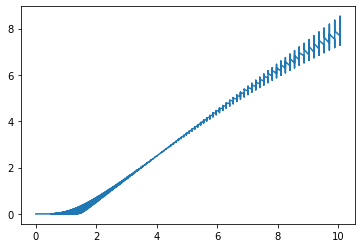

In [19]:
arg_sorted = S_vec.argsort()
plt.plot(S_vec[arg_sorted],Pc[arg_sorted])

In [9]:
%%time
np.dot(mat_xv,Pc)

CPU times: user 1.18 s, sys: 1.14 s, total: 2.32 s
Wall time: 3.87 s


array([ 0.00000000e+00, -7.83643164e-66, -2.25814603e-64, ...,
        9.72468772e-02,  9.82632937e-02,  9.96259782e-02])

In [10]:
%%time
mat_xv_csr.dot(Pc)

CPU times: user 628 µs, sys: 1.34 ms, total: 1.97 ms
Wall time: 1.72 ms


array([ 0.00000000e+00, -7.83643164e-66, -2.25814603e-64, ...,
        9.72468772e-02,  9.82632937e-02,  9.96259782e-02])